ENTORNO DE EJECUCION CPU

In [1]:
import numpy as np
import os
import gzip
def load_mnist(ruta, tipo='train'):
    ruta_categorias = os.path.join(ruta, '%s-labels-idx1-ubyte.gz' % tipo)
    ruta_imagenes = os.path.join(ruta, '%s-images-idx3-ubyte.gz' % tipo)
    with gzip.open(ruta_categorias, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 734)
    return imagenes, etiquetas

In [3]:
import numpy as np
import gzip

def load_mnist(ruta, tipo='train'):
    if tipo == 'train':
        ruta_imagenes = ruta + '/train-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/train-labels-idx1-ubyte.gz'
    elif tipo == 'test':
        ruta_imagenes = ruta + '/t10k-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/t10k-labels-idx1-ubyte.gz'
    else:
        raise ValueError("El tipo debe ser 'train' o 'test'.")

    with gzip.open(ruta_etiquetas, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        # Modify the reshape to (number_of_images, 28, 28)
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 28, 28)
    return imagenes, etiquetas


*Acceso a datos almacenados en drive*

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

ruta = '/content/gdrive/MyDrive/Procesamiento_QuispeLopez/Unidad 2/Tarea05/laboratorio 11/The_MNIST_Database'

X_train, Y_train = load_mnist(ruta, tipo='train')
X_test, Y_test = load_mnist(ruta, tipo='test')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


*Reshape de los datos para garantizar que sean matrices (no vectores)*

In [16]:
X_train = X_train[0:59904, :]
X_test = X_test[0:9984,:]
Y_train = Y_train[0:59904]
Y_test = Y_test[0:9984]

X_train = np.reshape(X_train, (59904, 28,28,1))
X_test = np.reshape(X_test,(9984,28,28,1))

*Creacion del modelo con TensorFlow 2 + Keras*

In [9]:
%tensorflow_version 2.x # Para garantizar que la versidn 2.x sea importada
import tensorflow as tf
print('Version de TensorFlow: ' + tf.__version__)

tf.random.set_seed(200)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Version de TensorFlow: 2.12.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)     

# **Entrenamiento con CPU**

In [17]:
import timeit

def entrenamiento_cpu():
  with tf.device('/cpu:0'):
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=128, epochs=2, verbose=1)
  return None

cpu_time = timeit.timeit('entrenamiento_cpu()', number=1, setup='from __main__ import entrenamiento_cpu')
#print('Tiempo de entrenamiento: ' + str(cpu_time) + ' segundos')


Epoch 1/2
468/468 [==============================] - 829s 2s/step - loss: 0.3208 - accuracy: 0.9176 - val_loss: 0.0471 - val_accuracy: 0.9862
Epoch 2/2
468/468 [==============================] - 826s 2s/step - loss: 0.1001 - accuracy: 0.9729 - val_loss: 0.0389 - val_accuracy: 0.9887


In [22]:
print('Tiempo de entrenamiento: ' + str(cpu_time) + ' segundos')

Tiempo de entrenamiento: 1655.044463739 segundos


##

######

#########################

**Entorno de ejecucion GPU**

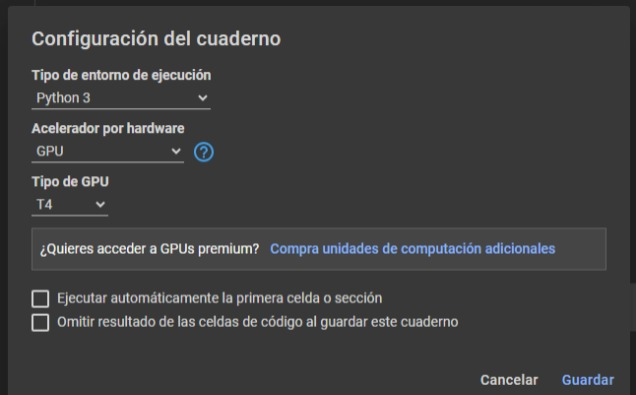

In [1]:
import numpy as np
import os
import gzip
def load_mnist(ruta, tipo='train'):
    ruta_categorias = os.path.join(ruta, '%s-labels-idx1-ubyte.gz' % tipo)
    ruta_imagenes = os.path.join(ruta, '%s-images-idx3-ubyte.gz' % tipo)
    with gzip.open(ruta_categorias, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 734)
    return imagenes, etiquetas

In [2]:
import numpy as np
import gzip

def load_mnist(ruta, tipo='train'):
    if tipo == 'train':
        ruta_imagenes = ruta + '/train-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/train-labels-idx1-ubyte.gz'
    elif tipo == 'test':
        ruta_imagenes = ruta + '/t10k-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/t10k-labels-idx1-ubyte.gz'
    else:
        raise ValueError("El tipo debe ser 'train' o 'test'.")

    with gzip.open(ruta_etiquetas, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        # Modify the reshape to (number_of_images, 28, 28)
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 28, 28)
    return imagenes, etiquetas


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

ruta = '/content/gdrive/MyDrive/Procesamiento_QuispeLopez/Unidad 2/Tarea05/laboratorio 11/The_MNIST_Database'

X_train, Y_train = load_mnist(ruta, tipo='train')
X_test, Y_test = load_mnist(ruta, tipo='test')

Mounted at /content/gdrive


In [4]:
X_train = X_train[0:59904, :]
X_test = X_test[0:9984,:]
Y_train = Y_train[0:59904]
Y_test = Y_test[0:9984]

X_train = np.reshape(X_train, (59904, 28,28,1))
X_test = np.reshape(X_test,(9984,28,28,1))

In [5]:
%tensorflow_version 2.x # Para garantizar que la versidn 2.x sea importada
import tensorflow as tf
print('Version de TensorFlow: ' + tf.__version__)

tf.random.set_seed(200)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Version de TensorFlow: 2.12.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)     

In [8]:
import tensorflow as tf

nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
    raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))


GPU encontrada: /device:GPU:0


In [13]:
import timeit

def entrenamiento_gpu():
    with tf.device('/device:GPU:0'):
        model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=128, epochs=2, verbose=1)
    return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')
print('Tiempo de entrenamiento en GPU:', gpu_time)


Epoch 1/2
468/468 [==============================] - 24s 24ms/step - loss: 0.3312 - accuracy: 0.9142 - val_loss: 0.0592 - val_accuracy: 0.9834
Epoch 2/2
468/468 [==============================] - 10s 22ms/step - loss: 0.1068 - accuracy: 0.9712 - val_loss: 0.0440 - val_accuracy: 0.9866
Tiempo de entrenamiento en GPU: 41.281413321999935


In [14]:
print('Tiempo de entrenamiento: ' + str(gpu_time) + ' segundos')

Tiempo de entrenamiento: 41.281413321999935 segundos


#

##

#############


#############################

ENTORNO DE EJECUCION TPU

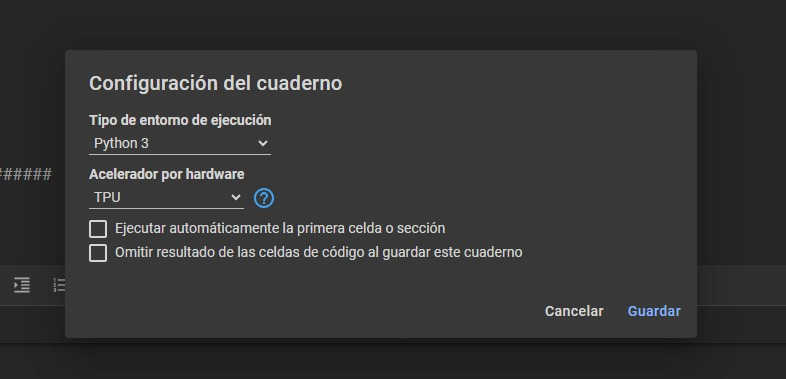

In [1]:
import numpy as np
import os
import gzip
def load_mnist(ruta, tipo='train'):
    ruta_categorias = os.path.join(ruta, '%s-labels-idx1-ubyte.gz' % tipo)
    ruta_imagenes = os.path.join(ruta, '%s-images-idx3-ubyte.gz' % tipo)
    with gzip.open(ruta_categorias, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 734)
    return imagenes, etiquetas

In [2]:
import numpy as np
import gzip

def load_mnist(ruta, tipo='train'):
    if tipo == 'train':
        ruta_imagenes = ruta + '/train-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/train-labels-idx1-ubyte.gz'
    elif tipo == 'test':
        ruta_imagenes = ruta + '/t10k-images-idx3-ubyte.gz'
        ruta_etiquetas = ruta + '/t10k-labels-idx1-ubyte.gz'
    else:
        raise ValueError("El tipo debe ser 'train' o 'test'.")

    with gzip.open(ruta_etiquetas, 'rb') as rut_cat:
        etiquetas = np.frombuffer(rut_cat.read(), dtype=np.uint8, offset=8)
    with gzip.open(ruta_imagenes, 'rb') as rut_imgs:
        # Modify the reshape to (number_of_images, 28, 28)
        imagenes = np.frombuffer(rut_imgs.read(), dtype=np.uint8, offset=16).reshape(len(etiquetas), 28, 28)
    return imagenes, etiquetas


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

ruta = '/content/gdrive/MyDrive/Procesamiento_QuispeLopez/Unidad 2/Tarea05/laboratorio 11/The_MNIST_Database'

X_train, Y_train = load_mnist(ruta, tipo='train')
X_test, Y_test = load_mnist(ruta, tipo='test')

Mounted at /content/gdrive


In [5]:
X_train = X_train[0:59904, :]
X_test = X_test[0:9984,:]
Y_train = Y_train[0:59904]
Y_test = Y_test[0:9984]

X_train = np.reshape(X_train, (59904, 28,28,1))
X_test = np.reshape(X_test,(9984,28,28,1))

In [10]:
%tensorflow_version 2.x # Para garantizar que la versidn 2.x sea importada
import tensorflow as tf
print('Version de TensorFlow:' + tf.__version__)
tf.random.set_seed(200)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']) # D
  print('TPU encontrada ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: TPU no encontrada!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Version de TensorFlow:2.12.0
TPU encontrada  ['10.0.47.114:8470']


In [12]:
with tpu_strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.Activation('sigmoid'))

    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [15]:
import timeit

x_train = X_train.astype(np.float32)
y_train = Y_train.astype(np.float32)
x_test = X_test.astype(np.float32)
y_test = Y_test.astype(np.float32)

def entrenamiento_tpu():
    model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=2, verbose=1)
    return None

tpu_time = timeit.timeit('entrenamiento_tpu()', number=1, setup='from __main__ import entrenamiento_tpu')
print(f"Tiempo de entrenamiento con TPU: {tpu_time:.2f} segundos")

Epoch 1/2
468/468 [==============================] - 16s 20ms/step - loss: -790320064.0000 - accuracy: 0.1123 - val_loss: -4620663296.0000 - val_accuracy: 0.1135
Epoch 2/2
468/468 [==============================] - 8s 18ms/step - loss: -32745580544.0000 - accuracy: 0.1124 - val_loss: -102055854080.0000 - val_accuracy: 0.1135
Tiempo de entrenamiento con TPU: 27.21 segundos


In [16]:
print('Tiempo de entrenamiento: ' + str(tpu_time) + ' segundos')

Tiempo de entrenamiento: 27.21104626500005 segundos
